In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/london_smartmeter_basic.csv")

In [3]:
df.shape

(827, 3)

In [4]:
df.head()

,day,consumption,evaluation_set
0,2011-11-24,7.7580,False
1,2011-11-25,8.7385,False
2,2011-11-26,9.4770,False
3,2011-11-27,9.8030,False
4,2011-11-28,7.0690,False


### Preprocess section

In [10]:
# reindex to day
df.set_index(pd.to_datetime(df.day), inplace=True)
df.drop(['day'],axis=1, inplace=True)

# split into train and eval
ts_eval = df.loc[df.evaluation_set]
ts = df.loc[~df.evaluation_set]

In [11]:
ts.drop(['evaluation_set'], axis=1, inplace=True)
ts_eval.drop(['evaluation_set'], axis=1, inplace=True)
ts.head()

C:\Programs\Miniconda3\envs\ADS04\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,consumption
day,
2011-11-24,7.7580
2011-11-25,8.7385
2011-11-26,9.4770
2011-11-27,9.8030
2011-11-28,7.0690


### Model fit

In [12]:
from statsmodels.api import tsa

In [21]:
ar_model = tsa.AR(ts).fit()

C:\Programs\Miniconda3\envs\ADS04\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWar

In [26]:
ts_eval.index[0]

Timestamp('2014-02-01 00:00:00')

In [30]:
predict_ar = ar_model.predict(start=ts_eval.index[0], end= ts_eval.index[-1])
predict_ar

2014-02-01    9.115843
2014-02-02    9.132325
2014-02-03    8.835297
2014-02-04    8.683259
2014-02-05    8.712915
2014-02-06    8.827649
2014-02-07    8.751074
2014-02-08    8.907920
2014-02-09    9.276761
2014-02-10    8.855422
2014-02-11    8.604217
2014-02-12    8.744304
2014-02-13    8.708318
2014-02-14    8.728063
2014-02-15    8.955988
2014-02-16    9.043761
2014-02-17    8.776074
2014-02-18    8.612240
2014-02-19    8.654877
2014-02-20    8.719756
2014-02-21    8.715070
2014-02-22    8.836754
2014-02-23    8.996384
2014-02-24    8.745359
2014-02-25    8.571278
2014-02-26    8.649388
2014-02-27    8.653052
Freq: D, dtype: float64

In [32]:
decimate = np.arange(0,ts.shape[0],10)

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
       260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
       390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510,
       520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640,
       650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770,
       780, 790])

In [36]:
ts.iloc[-20:,:]

,consumption
day,
2014-01-12,9.6580
2014-01-13,8.6250
2014-01-14,8.5080
2014-01-15,8.5770
2014-01-16,8.4920
2014-01-17,8.4990
2014-01-18,8.8450
2014-01-19,8.3540
2014-01-20,8.6330


In [40]:
p = 3
q = 3
arma_model = tsa.ARMA(ts, (p, q)).fit()

C:\Programs\Miniconda3\envs\ADS04\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Programs\Miniconda3\envs\ADS04\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [41]:
predict_arma = arma_model.predict(start=ts_eval.index[0], end= ts_eval.index[-1])

In [47]:
from fbprophet import Prophet

# It also expects these columns to have the names 'ds' and 'y', so we rename them accordingly

ts_a = ts.reset_index().rename(columns={'day': 'ds', 'consumption': 'y'})


In [50]:
forecast_model = Prophet( growth='linear',  weekly_seasonality=5, yearly_seasonality=5)
forecast_model.fit(ts_a)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


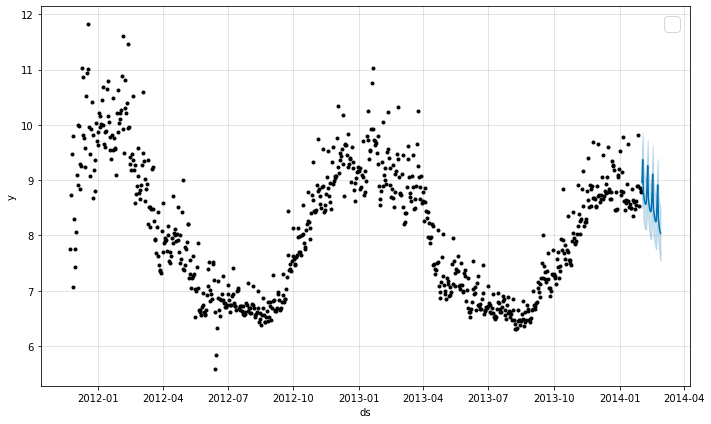

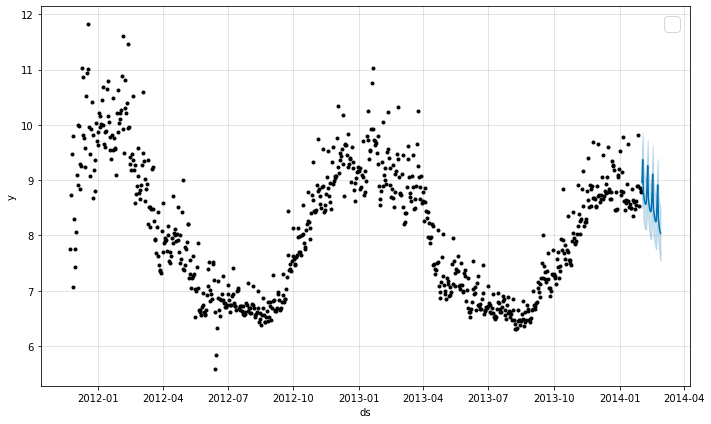

In [53]:
# we can now study the fit of the model - in order to do so, we need to creat another df
ts_eval_a = ts_eval.reset_index().rename(columns={'day': 'ds', 'consumption': 'y'})

model_predictions = forecast_model.predict( ts_eval_a )
plot_pred = forecast_model.plot( model_predictions )
plt.legend(loc='best', fontsize=20)
plot_pred

In [57]:
model_predictions['yhat']

0     8.957803
1     9.371032
2     8.791484
3     8.676944
4     8.601078
5     8.561397
6     8.581283
7     8.854112
8     9.261290
9     8.675608
10    8.554867
11    8.472751
12    8.426790
13    8.440387
14    8.706937
15    9.107867
16    8.515989
17    8.389122
18    8.300973
19    8.249092
20    8.256900
21    8.517815
22    8.913280
23    8.316125
24    8.184188
25    8.091191
26    8.034701
Name: yhat, dtype: float64

In [65]:
y_predict_p = model_predictions[['ds','yhat']] 
y_predict_p['day'] = y_predict_p['ds']
y_predict_p.set_index(pd.to_datetime(y_predict_p.day), inplace=True)
y_predict_p.drop(['day','ds'],axis=1, inplace=True)

C:\Programs\Miniconda3\envs\ADS04\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Programs\Miniconda3\envs\ADS04\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [72]:
y_predict_p['yhat']

day
2014-02-01    8.957803
2014-02-02    9.371032
2014-02-03    8.791484
2014-02-04    8.676944
2014-02-05    8.601078
2014-02-06    8.561397
2014-02-07    8.581283
2014-02-08    8.854112
2014-02-09    9.261290
2014-02-10    8.675608
2014-02-11    8.554867
2014-02-12    8.472751
2014-02-13    8.426790
2014-02-14    8.440387
2014-02-15    8.706937
2014-02-16    9.107867
2014-02-17    8.515989
2014-02-18    8.389122
2014-02-19    8.300973
2014-02-20    8.249092
2014-02-21    8.256900
2014-02-22    8.517815
2014-02-23    8.913280
2014-02-24    8.316125
2014-02-25    8.184188
2014-02-26    8.091191
2014-02-27    8.034701
Name: yhat, dtype: float64

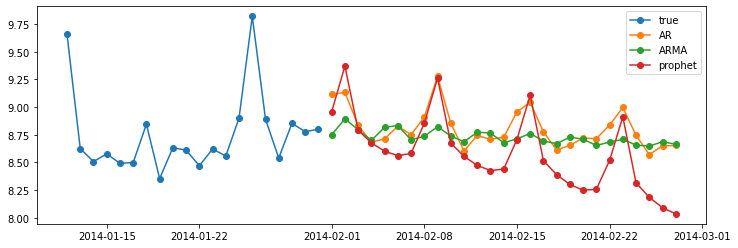

In [67]:
plt.figure(figsize=(12, 4))
plt.plot(ts.iloc[-20:,:], '-o', label='true')
plt.plot(predict_ar, '-o', label='AR')
plt.plot(predict_arma, '-o', label='ARMA')
plt.plot(y_predict_p, '-o', label='prophet')
plt.legend();

In [68]:
predict_arma.dtype

dtype('float64')

In [71]:
type(predict_arma)

pandas.core.series.Series